# Training and Basic Evaluation for a 2D Binary Classifier

If using MedMNIST for the first time, you will need to install medmnist.

In [1]:
#!pip install medmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, build_basic_model, argmax_array, generate_training_mixup_images
from plotting_functions import plot_history

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


We set some of our parameters here. The data flag is 'pneumoniamnist' - a binary pneumonia dataset. 

In [3]:
data_flag = 'pneumoniamnist'

download = True

image_size = 128

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [4]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz


In [5]:
print(train_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


Here we split our data into train, validation, and 2 testing datasets. One is for MUBA, one is for further evaluation. 

In [6]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=2, image_size = 128)

print(y_train)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [0 1]]


In [7]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ["Normal","Pneumonia"])


Train
{(0, 1): 3494, (1, 0): 1214}  ['Normal', 'Pneumonia']

Val
{(0, 1): 389, (1, 0): 135}  ['Normal', 'Pneumonia']

Test A
{(0, 1): 117, (1, 0): 70}  ['Normal', 'Pneumonia']

Test B
{(0, 1): 273, (1, 0): 164}  ['Normal', 'Pneumonia']


## Basic Model 

This first model we call 'basic' as we are not augmenting the data in any way during training. 

In [8]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        2

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./simple_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"simple_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [11]:
history = model.fit(X_train,y_train, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
148/148 [==============================] - 52s 343ms/step - loss: 0.3986 - accuracy: 0.9044 - val_loss: 5.4627 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 50s 337ms/step - loss: 0.1638 - accuracy: 0.9465 - val_loss: 0.8743 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 47s 318ms/step - loss: 0.1126 - accuracy: 0.9613 - val_loss: 0.7642 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - 46s 311ms/step - loss: 0.1042 - accuracy: 0.9662 - val_loss: 0.2199 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 49s 331ms/step - loss: 0.0835 - accuracy: 0.9728 - val_loss: 0.2170 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 6/30
148/148 [==============================] - 52s 353ms/step - loss: 0.0784 - accuracy: 0.9728 - val_loss: 0.1831 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 7/30
148/148 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9756
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 54s 36

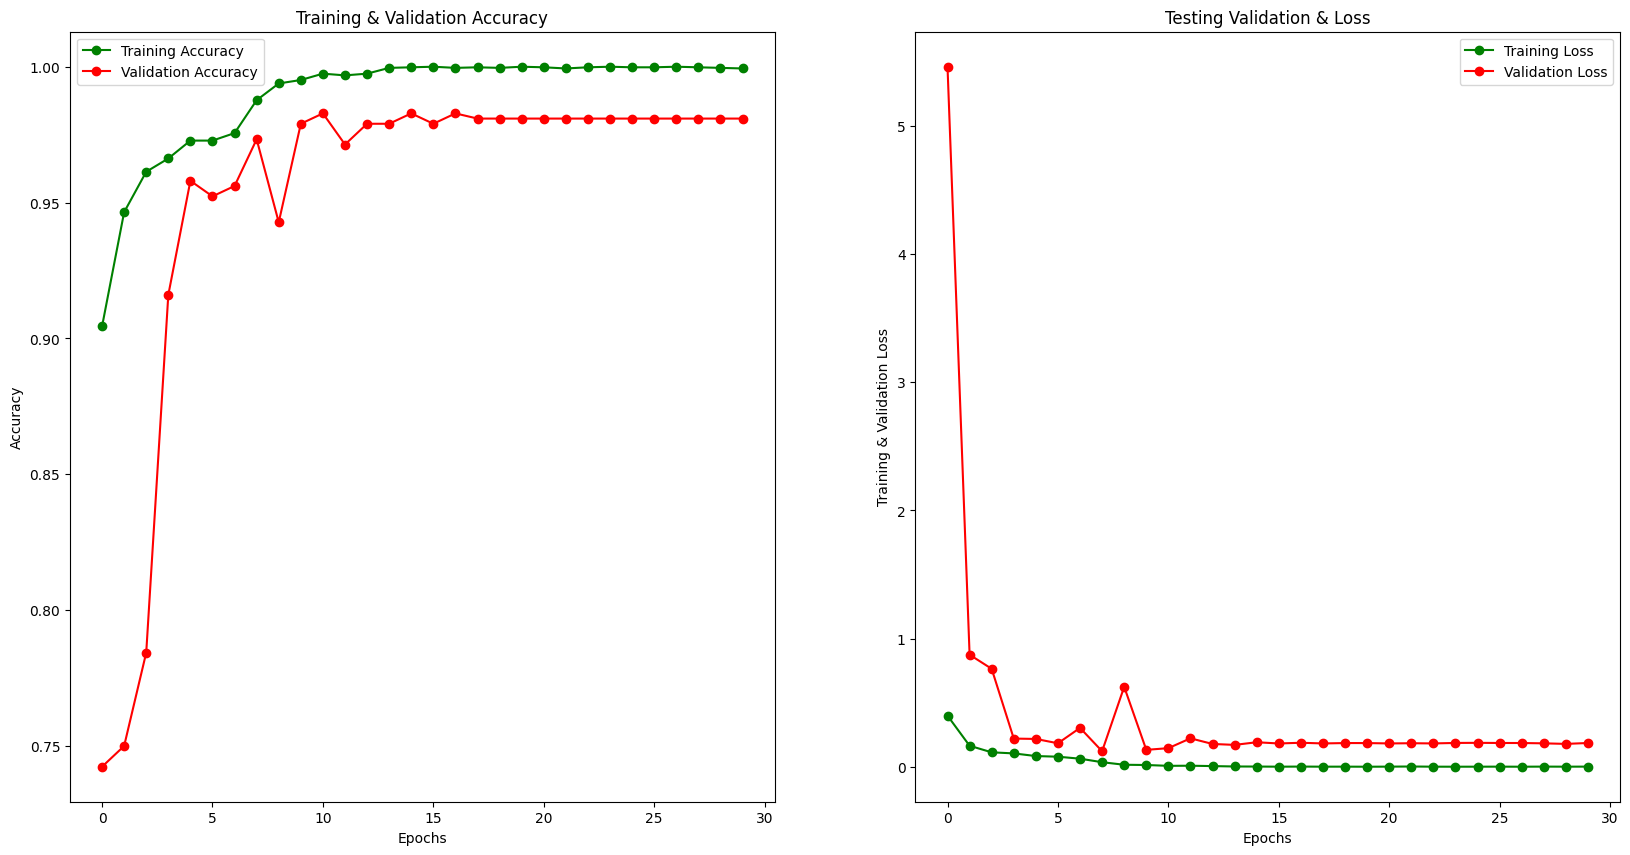

In [12]:
plot_history(history, size=(20,10), epochs = 30)

In [13]:
print(history.history["accuracy"])
print(history.history["loss"])
print(history.history["val_accuracy"])
print(history.history["val_loss"])

[0.9044179916381836, 0.9464740753173828, 0.9613423943519592, 0.9662277102470398, 0.9728122353553772, 0.9728122353553772, 0.9755734801292419, 0.9876805543899536, 0.9938402771949768, 0.9951146841049194, 0.99745112657547, 0.996813952922821, 0.99745112657547, 0.9995751976966858, 0.9997875690460205, 1.0, 0.9995751976966858, 0.9997875690460205, 0.9995751976966858, 1.0, 0.9997875690460205, 0.9993627667427063, 0.9997875690460205, 1.0, 0.9997875690460205, 0.9997875690460205, 1.0, 0.9997875690460205, 0.9995751976966858, 0.9993627667427063]
[0.398616224527359, 0.16384005546569824, 0.11260361224412918, 0.10416805744171143, 0.08352751284837723, 0.07843728363513947, 0.06294231116771698, 0.03546155244112015, 0.015554368495941162, 0.013662189245223999, 0.007157270796597004, 0.00807880237698555, 0.005170808173716068, 0.002110424218699336, 0.0015722160460427403, 0.0005646123900078237, 0.001350359176285565, 0.0006192545406520367, 0.0007995869382284582, 0.00023654609685763717, 0.0009411856881342828, 0.001

In [9]:
best_model = keras.models.load_model("./simple_models/best_model_epoch_08.h5")

In [12]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 1s 65ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.57      0.73        70
Pneumonia (Class 1)       0.80      1.00      0.89       117

           accuracy                           0.84       187
          macro avg       0.90      0.79      0.81       187
       weighted avg       0.87      0.84      0.83       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.56      0.71       164
Pneumonia (Class 1)       0.79      0.99      0.88       273

           accuracy                           0.83       437
          macro avg       0.88      0.77      0.79       437
       weighted avg       0.86      0.83      0.82       437

Test Set A
[[ 40  30]
 [  0 117]]

Test Set B
[[ 92  72]
 [  3 270]]


## Advanced Model

We call this model 'advanced' as we will use datagen to augment the data each epoch. We use random rotation, width adn height shifts, and horizontal flips. 

In [13]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 64)       

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./advance_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./advance_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [16]:
history_2 = model.fit(datagen.flow(X_train,y_train, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)


Epoch 1/30
148/148 [==============================] - 51s 340ms/step - loss: 0.5755 - accuracy: 0.8592 - val_loss: 0.2826 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 53s 360ms/step - loss: 0.2675 - accuracy: 0.9048 - val_loss: 0.7430 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 55s 373ms/step - loss: 0.2070 - accuracy: 0.9269 - val_loss: 0.3363 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - 57s 382ms/step - loss: 0.1764 - accuracy: 0.9367 - val_loss: 4.7126 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 55s 372ms/step - loss: 0.1624 - accuracy: 0.9463 - val_loss: 0.1379 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 6/30
148/148 [==============================] - 61s 413ms/step - loss: 0.1413 - accuracy: 0.9524 - val_loss: 0.2325 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 7/30
148/148 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9526
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 54s 36

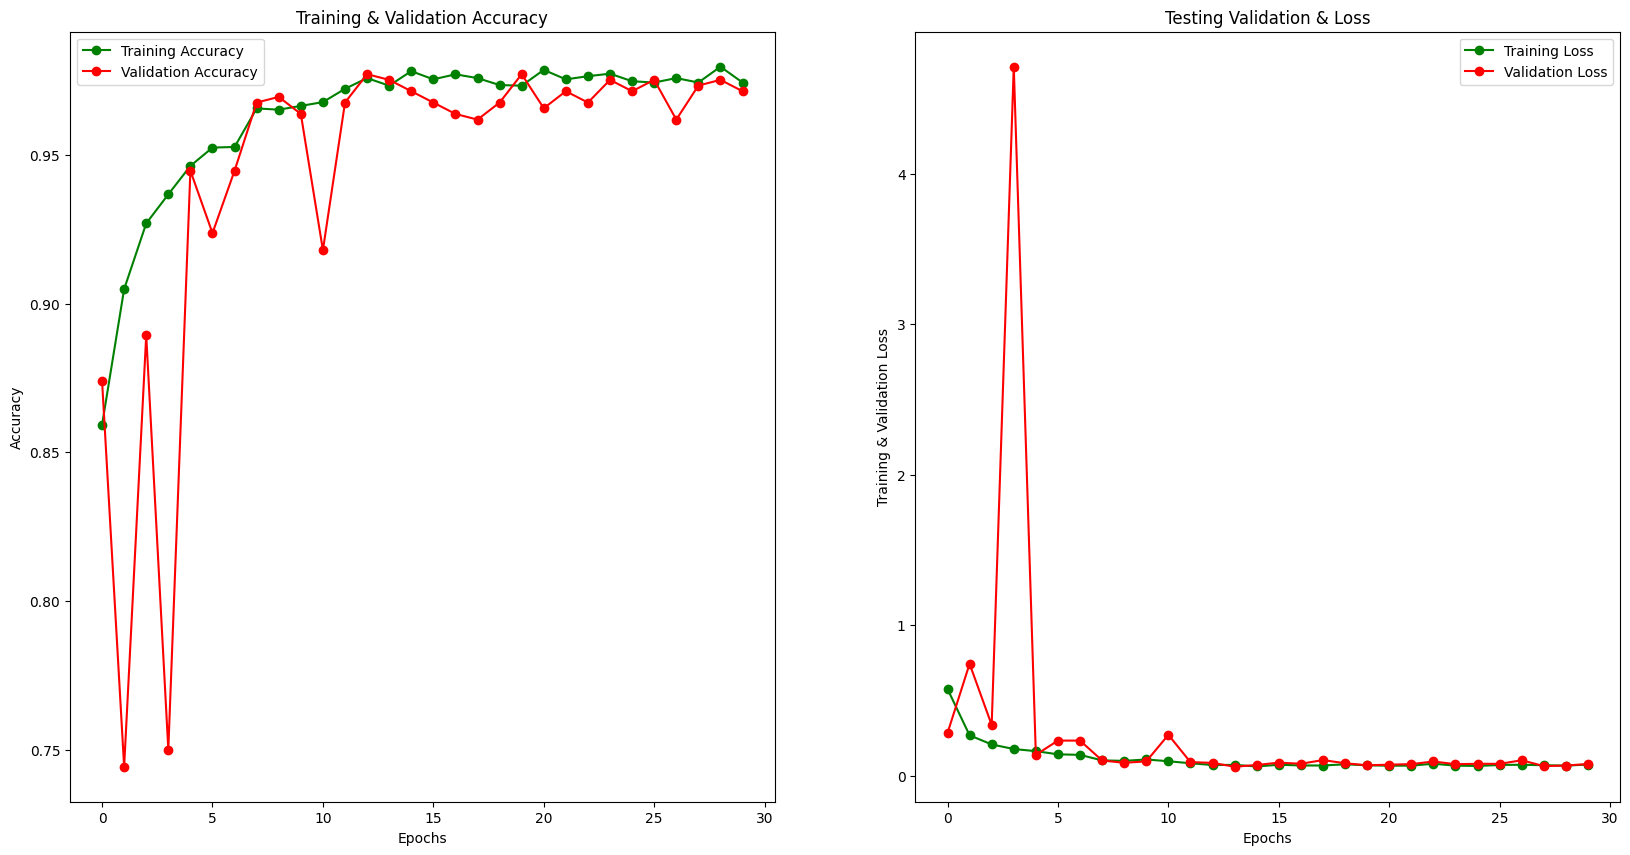

In [17]:
plot_history(history_2, size=(20,10), epochs = 30)

In [18]:
best_model = keras.models.load_model("./advance_models/best_model_epoch_14.h5")

In [19]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 1s 71ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.74      0.85        70
Pneumonia (Class 1)       0.87      1.00      0.93       117

           accuracy                           0.90       187
          macro avg       0.93      0.87      0.89       187
       weighted avg       0.92      0.90      0.90       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.74      0.84       164
Pneumonia (Class 1)       0.86      0.99      0.92       273

           accuracy                           0.89       437
          macro avg       0.92      0.86      0.88       437
       weighted avg       0.91      0.89      0.89       437

Test Set A
[[ 52  18]
 [  0 117]]

Test Set B
[[121  43]
 [  3 270]]


In [20]:
print(history_2.history["accuracy"])
print(history_2.history["loss"])
print(history_2.history["val_accuracy"])
print(history_2.history["val_loss"])

[0.8591758608818054, 0.9048427939414978, 0.9269328713417053, 0.9367035031318665, 0.9462617039680481, 0.9524214267730713, 0.952633798122406, 0.9655904769897461, 0.9651656746864319, 0.9664400815963745, 0.9677145481109619, 0.9721750020980835, 0.9757859110832214, 0.9732370376586914, 0.978122353553772, 0.9753611087799072, 0.9770603179931641, 0.9757859110832214, 0.9734494686126709, 0.9732370376586914, 0.9785471558570862, 0.9753611087799072, 0.9764230847358704, 0.9772727489471436, 0.9747238755226135, 0.9742990732192993, 0.9757859110832214, 0.9742990732192993, 0.9796091914176941, 0.9742990732192993]
[0.5755118727684021, 0.26753154397010803, 0.20702233910560608, 0.17639827728271484, 0.16240698099136353, 0.141276553273201, 0.13759981095790863, 0.100875124335289, 0.09786058217287064, 0.10700179636478424, 0.095292828977108, 0.08178865909576416, 0.0700778067111969, 0.07118412107229233, 0.06042388454079628, 0.07189231365919113, 0.06717826426029205, 0.06691160053014755, 0.07496092468500137, 0.0683745

In [21]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train, y_train)

Text(0.5, 1.0, '[0.34475158 0.65524842]')

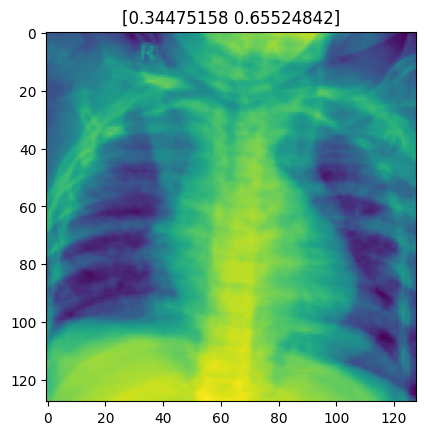

In [25]:
ID = random.randint(0,len(y_train_mixup)-1)
plt.imshow(X_train_mixup[ID])
plt.title(y_train_mixup[ID])

In [26]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, 1)
y_train_mixup = np.array(y_train_mixup)

In [27]:
len(X_train_mixup),len(y_train_mixup)

(4708, 4708)

## Mixup Model

In this model, we use mixup augmentation to train the model. 

In [28]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_11 (Ba  (None, 64, 64, 64)       

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./mixup_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./mixup_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [30]:
history_3 = model.fit(X_train_mixup,y_train_mixup, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
148/148 [==============================] - 57s 376ms/step - loss: 0.6133 - accuracy: 0.8456 - val_loss: 0.3319 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 65s 441ms/step - loss: 0.3832 - accuracy: 0.9097 - val_loss: 0.2755 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 66s 446ms/step - loss: 0.3412 - accuracy: 0.9259 - val_loss: 0.2031 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - 61s 410ms/step - loss: 0.3193 - accuracy: 0.9352 - val_loss: 0.1439 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 57s 387ms/step - loss: 0.3129 - accuracy: 0.9399 - val_loss: 0.2113 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 6/30
148/148 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.9477
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 49s 329ms/step - loss: 0.2956 - accuracy: 0.9477 - val_loss: 0.1368 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 7/30
148/148 [==============================] - 50s 34

In [32]:
best_model = keras.models.load_model("./mixup_models/best_model_epoch_11.h5")

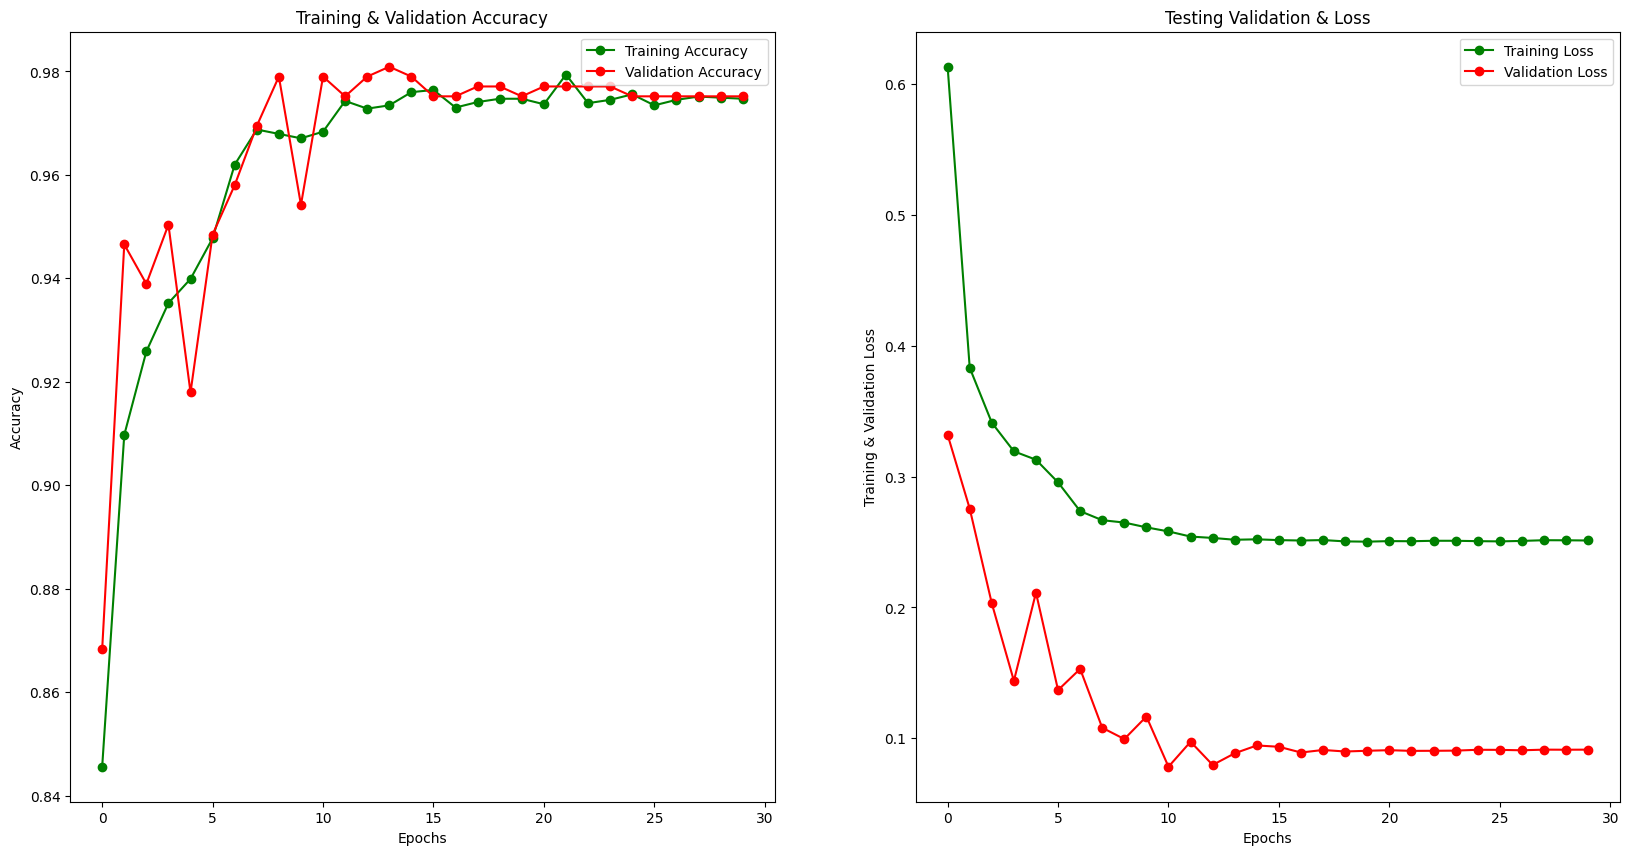

In [34]:
plot_history(history_3, size=(20,10), epochs = 30)

In [33]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 1s 68ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.63      0.77        70
Pneumonia (Class 1)       0.82      1.00      0.90       117

           accuracy                           0.86       187
          macro avg       0.91      0.81      0.84       187
       weighted avg       0.89      0.86      0.85       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.59      0.73       164
Pneumonia (Class 1)       0.80      0.99      0.89       273

           accuracy                           0.84       437
          macro avg       0.89      0.79      0.81       437
       weighted avg       0.87      0.84      0.83       437

Test Set A
[[ 44  26]
 [  0 117]]

Test Set B
[[ 96  68]
 [  2 271]]


## Oversampling

In [39]:
X_train_oversample = []
y_train_oversample = []

for X, y in zip(X_train,y_train):
    if y[0] == 1: # Normal is undersampled
        for i in range(3):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    else:
        X_train_oversample.append(X)
        y_train_oversample.append(y)

X_train_oversample = np.array(X_train_oversample).reshape(-1, image_size, image_size, 1)
y_train_oversample = np.array(y_train_oversample)

In [40]:
get_label_counts(y_train_oversample,y_val,y_test_A,y_test_B,class_names = ["Normal","Pneumonia"])


Train
{(0, 1): 3494, (1, 0): 3642}  ['Normal', 'Pneumonia']

Val
{(0, 1): 389, (1, 0): 135}  ['Normal', 'Pneumonia']

Test A
{(0, 1): 117, (1, 0): 70}  ['Normal', 'Pneumonia']

Test B
{(0, 1): 273, (1, 0): 164}  ['Normal', 'Pneumonia']


In [41]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 64, 64, 64)       

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [48]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_oversample)

In [49]:
history_4 = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
223/223 [==============================] - 74s 333ms/step - loss: 0.3226 - accuracy: 0.8847 - val_loss: 0.8301 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 72s 321ms/step - loss: 0.2392 - accuracy: 0.9154 - val_loss: 0.1982 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 3/30
223/223 [==============================] - 76s 339ms/step - loss: 0.1992 - accuracy: 0.9277 - val_loss: 0.2901 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 4/30
223/223 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9382
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
223/223 [==============================] - 74s 333ms/step - loss: 0.1829 - accuracy: 0.9382 - val_loss: 0.3708 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 5/30
223/223 [==============================] - 75s 337ms/step - loss: 0.1345 - accuracy: 0.9532 - val_loss: 0.1226 - val_accuracy: 0.9599 - lr: 3.0000e-04
Epoch 6/30
223/223 [==============================] - 75s 338ms/step - loss: 0.1292 - accuracy: 0.9524 - val_loss: 0.1399 - val_accuracy: 0.9447 - lr: 3.0000e-04
Epoch 7/30
223/223 [==============================] 

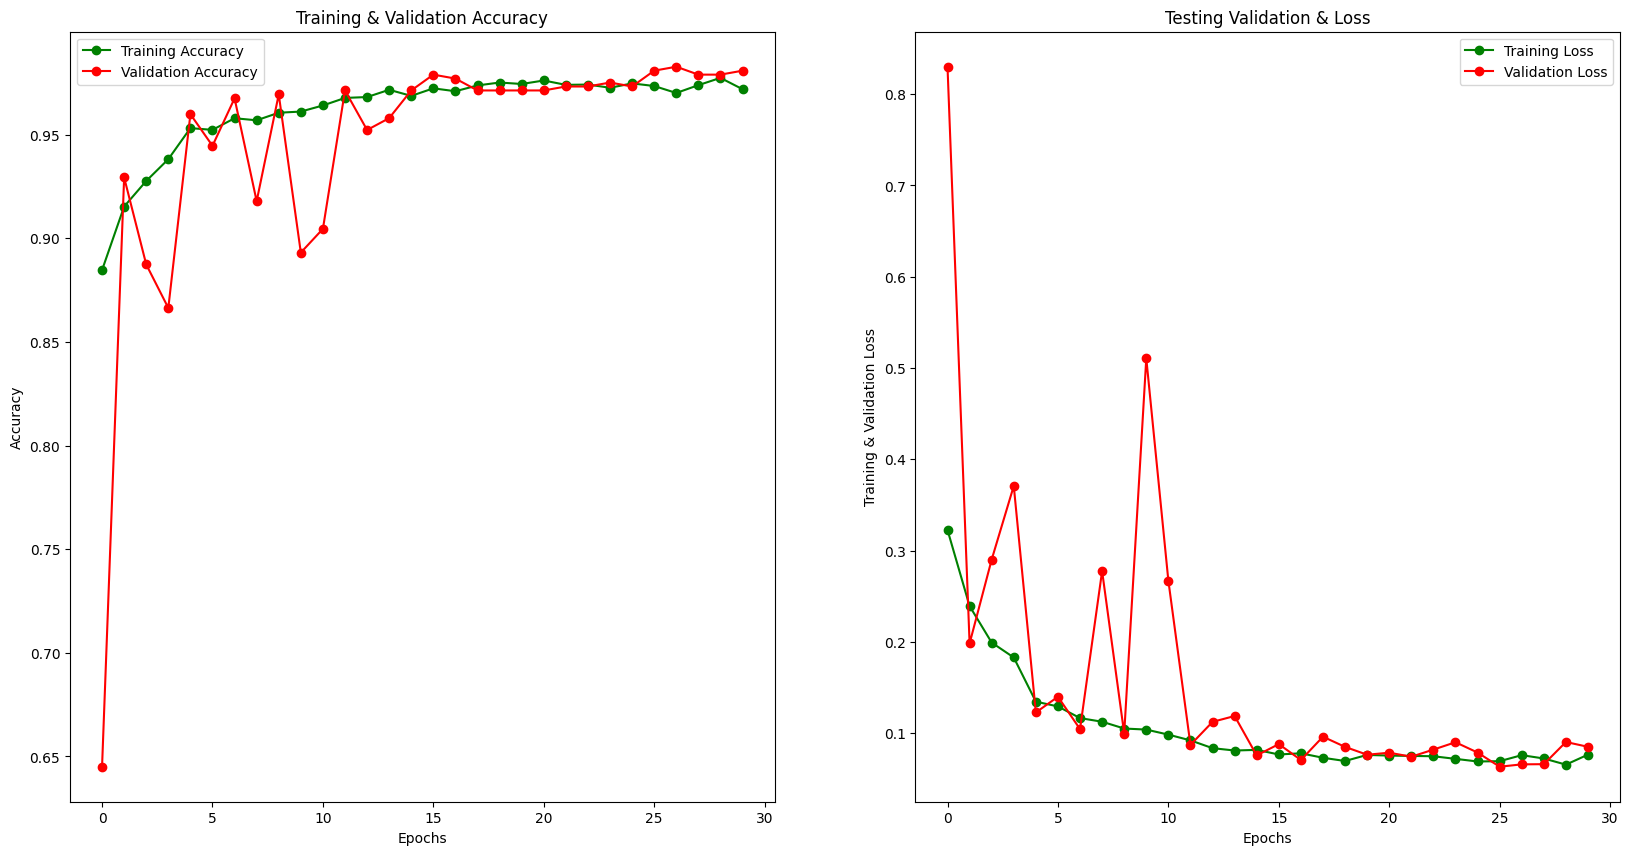

In [50]:
plot_history(history_4, size=(20,10), epochs = 30)

In [51]:
best_model = keras.models.load_model("./oversample_models/best_model_epoch_26.h5")

In [52]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 1s 66ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.87      0.92        70
Pneumonia (Class 1)       0.93      0.98      0.95       117

           accuracy                           0.94       187
          macro avg       0.95      0.93      0.94       187
       weighted avg       0.94      0.94      0.94       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.85      0.91       164
Pneumonia (Class 1)       0.92      0.99      0.95       273

           accuracy                           0.94       437
          macro avg       0.95      0.92      0.93       437
       weighted avg       0.94      0.94      0.93       437

Test Set A
[[ 61   9]
 [  2 115]]

Test Set B
[[140  24]
 [  4 269]]
